# Creating a .hdf5 file with fluorescent peaks coordinates from raw (.stk files) from microscope

This program takes multiple .stk files as an input and has a .hdf5 file of fluorescent peaks coordinates as an output.
It performs these steps:
- Determines on which frame the analysis should start in each .stk file (first frame is blank and we have to start on an odd frame)
- Concatenates multiple .stk files into single .tif file
- Using STORM analysis package detects fluorescent peaks on each frame and writes information in a .hdf5 file

Rijksuniversiteit Groningen, 2021

C.M. Punter (c.m.punter@rug.nl)

W.M. Smigiel (w.m.smigiel@gmail.com)

D.S. Linnik (d.s.linnik@rug.nl)

L. Mantovanelli (l.mantovanelli@rug.nl)

concatenating stk files...
Time to concatinate : 6.77 sec
finding peaks...
Time to find pecks  : 698.42 sec


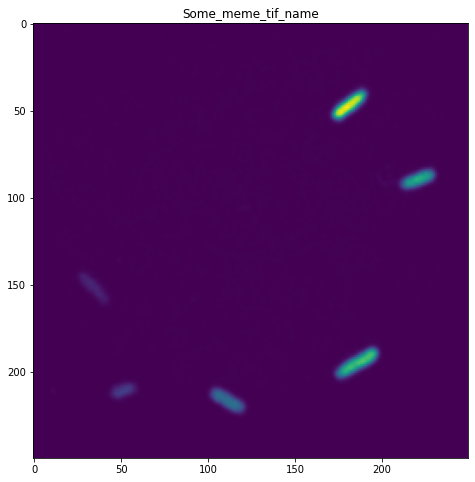

In [18]:
import numpy as np
import os
import time
import struct
import tifffile
from IPython.utils import io

import matplotlib
import matplotlib.pyplot as plt

import storm_analysis.sa_library.parameters as params
import storm_analysis.daostorm_3d.mufit_analysis as mfit
import storm_analysis.sa_utilities.hdf5_to_image as h5_image


path = os.getcwd()               # Determine path to the skt files
name_of_output_tif = "Tif_name"  # Name of an output tif file

# Define which steps need to be performed
CONCATENATE = True
FIND_PEAKS = True


class StkFile:
    """
    
    This class reads stk files and can also handle stk files that are bigger than 4 GB in size.
    
    To read tags that are stored beyond the 4 GB boundary it is necessary to check if the offsets point to valid data.
    If not, then we need to add 0x100000000 to the address to get the correct address.
    
    Usage example :
    
    with StkFile('example.stk') as stk:
        # get all odd planes
        image = stk[0:stk.number_of_planes:2]
    
    with StkFile('example.stk') as stk:
        image = stk[10]
        
    Rijksuniversiteit Groningen, 2020
    C.M. Punter (c.m.punter@rug.nl)
    
    """
    def __init__(self, path):
        self.path = path
    
    def __read(self, fmt):
        fmt = self.byte_order + fmt
        return struct.unpack(fmt, self.f.read(struct.calcsize(fmt)))
    
    def __enter__(self):
        self.f = open(self.path, "rb")
        
        # read header
        self.byte_order = "<" if self.f.read(2) == b'II' else ">"
        tiff_identifier, offset = self.__read("HI")
        
        # raise an exception when this is not a valid tiff/stk header
        if tiff_identifier != 42:
            raise
        
        # read tags
        self.tags = {}
        while offset != 0:
            self.f.seek(offset)
            number_of_entries, = self.__read("H")
            
            for i in range(number_of_entries):
                tag, tag_type, count, value = self.__read("HHII")
                
                # when count > 1 then we know that value is actually an offset
                # if this offset is lower than the current offset then we know that we have to correct the offset (4GB problem)
                if count > 1 and value < offset:
                    value += 0x100000000
                    
                self.tags[tag] = (tag_type, count, value)
                
            offset, = self.__read("I")
            
        return self
    
    @property
    def width(self):
        return self.tags[256][2]
    
    @property
    def height(self):
        return self.tags[257][2]
    
    @property
    def bits_per_sample(self):
        return self.tags[258][2]
    
    @property
    def number_of_planes(self):
        return self.tags[33629][1]

    def __read_plane(self, i):
        size = self.width * self.height * self.bits_per_sample // 8
        self.f.seek(8 + i * size)
        return self.f.read(size)
        
    def __getitem__(self, i):
        ifnone = lambda a, b: b if a is None else a
        
        if isinstance(i, slice):
            buffer = bytearray()
            plane_count = 0
            for ii in range(ifnone(i.start, 0), ifnone(i.stop, self.number_of_planes), ifnone(i.step, 1)):
                buffer += self.__read_plane(ii)
                plane_count += 1
            return np.frombuffer(buffer, dtype=np.uint16 if self.bits_per_sample == 16 else uint8).reshape(plane_count, self.height, self.width)
        elif isinstance(i, int):
            return np.frombuffer(self.__read_plane(i), dtype=np.uint16 if self.bits_per_sample == 16 else uint8).reshape(self.height, self.width)
        else:
            raise TypeError
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.f.close()
        
        

def determine_first_image(movie):
    """ This function return the first frame on which a frame pair starts (counted from frame 0) 
        Based on intensivity of a frames. As we know that on odd frames backgrount intensivity 
        should be higher because of two laser inpulses in these frames
    """

    # get mean intensities
    mean_intensities = np.mean(movie, axis=(1,2))

    # determine mean intensities of even and odd frames
    even_mean_intensities = mean_intensities[2::2]
    odd_mean_intensities = mean_intensities[1::2]
    mean_even = np.mean(even_mean_intensities)
    mean_odd = np.mean(odd_mean_intensities)

    if mean_odd < mean_even:
        return 1
    else:
        return 2  # ignore the first 2 frames since it may include a blank frame

def concatenate_movies(movie_paths, output_path):
    """ This function concatenates stk files and also makes sure everything is synchronized 
        regarging sequence of frames (starting from on add frame)
    """
    concatenated = []

    with tifffile.TiffWriter(output_path, bigtiff=True) as tif_out:
        for path in movie_paths:
            print("appending %s to %s..." % (path, output_path))

            with StkFile(path) as stk:

                # determine starting frame from the first 10 frames
                start = determine_first_image(stk[:10])

                # make sure we have an even number of frames
                end = stk.number_of_planes - ((stk.number_of_planes - start) % 2)

                for frame in range(start, end):
                    tif_out.save(stk[frame])
                

def find_all_peaks(path, concatenated_path, fitted_peaks_path):
    """ Function for finding all the peaks on all frames in a tif file in at a given path.
        Hdf5 file with coordinates and frame numbers as an output.
        Uses function from STORM analysis package.
        
        NOTE!! - .xml file with parameters must be in the save directory as this notebook or 
        determine path to this file
    """
    # Insuering that important parameters of an analysis are correct
    daop = params.ParametersDAO().initFromFile("Parameters.xml") # If .xml file with parameters not in the same directory as this notebook - define full path to it
    daop.changeAttr("threshold", 25.0) 
    daop.changeAttr("find_max_radius", 5) # original value is 5 (pixels)
    daop.changeAttr("roi_size", 6) # original value is 9 (pixels)
    daop.changeAttr("sigma", 1)
    daop.changeAttr("radius", 1)
    daop.changeAttr("start_frame", -1)
    daop.changeAttr("max_frame", -1)
    daop.toXMLFile("Parameters.xml", pretty = True) # If .xml file with parameters not in the same directory as this notebook - define full path to it

    for out in os.listdir():
        
        # Delete previous hdf5 file
        if out.endswith('hdf5'):
            os.remove(out)
            
        # Search a tif file and make a hdf5 file based on it
        if out.endswith('.tif'):
            mfit.analyze(out, out[:-4] + '.hdf5', "Parameters.xml") # if .xml file with parameters not in the same directory as this notebook - define full path to it        
            
            sr_im = h5_image.render2DImage(out[:-4] + '.hdf5', scale = 1, sigma = 1)
            fig = plt.figure(figsize = (8, 8))
            ax = fig.add_subplot(1,1,1)
            ax.imshow(sr_im)
            ax.set_title(out[:-4])
            # Optionally saves a pickture of peack density
            plt.savefig(out[:-4] + '.png', dpi=600)


# Executive function 
def analyze(path):
    # Path to save tif file
    concatenated_path = os.path.join(path, name_of_output_tif+".tif")
    # Path to save hdf5 file
    fitted_peaks_path = os.path.join(path, "fitted_peaks.hdf5")
    
    # Makes a list all stk filenames
    stk_files = [os.path.join(path, fn) for fn in os.listdir(path) if fn.endswith(".stk")]
    
    # Make sure the files are sorted (e.g. 1.stk, 2.stk, 3.stk...)
    stk_files.sort()
    
    if CONCATENATE:
        # Serach for an .stk files in given path and concatinates them in a single .tif file using concatenate_movies function
        is_stk = False
        for out in os.listdir(path):
            if out.endswith('.stk'):
                is_stk = True
        if is_stk == False:
            raise Exception('No .stk files for concationation')
            
        # Terminal printing of runtime          
        print("concatenating stk files...")
        t_0_conc = time.time()
        with io.capture_output() as captured:
            concatenate_movies(stk_files, concatenated_path)
        t_1_conc = time.time()
        print("Time to concatinate : %a sec" % round((t_1_conc - t_0_conc),2))

    if FIND_PEAKS:
        # Serach for a .tif files in given path and writes found peaks in an .hdf5 file using find_all_peaks function
        is_tif = False
        for out in os.listdir(path):
            if out.endswith('.tif'):
                is_tif = True
        if is_tif == False:
            raise Exception('No .tif file for peck detection')
        
        # Terminal printing of runtime
        print("finding peaks...")
        t_0_find = time.time()
        with io.capture_output() as captured:
            find_all_peaks(path, concatenated_path, fitted_peaks_path)
        t_1_find = time.time()
        print("Time to find pecks  : %a sec" % round((t_1_find - t_0_find),2))
        
# Run the script         
analyze(path)

# Optionally delete intermediate txt file with drift correction information
for out in os.listdir():
    if out.endswith('txt'):
        os.remove(out)
